# XGBoost Classifier
## Librerias y parametros inciales

In [1]:
import lib.main_func_p1, lib.main_func_p2, lib.main_func_p3, lib.main_func_p4
from lib.main_func_p1 import path, timer
from lib.main_func_p4 import resampling_set

import numpy as np
import pandas as pd

# save the models
import pickle

from collections import OrderedDict
from importlib import reload

#XGBoost library
import xgboost as xgb

In [2]:
# proteina (uniprot_ID)
uniprot_id = 'P36544'
path_file = path(uniprot_id)

# Parametros
seed = 142857
fp_name = 'morgan2_c'

## Carga datos

### Load external validation dataset

In [3]:
df_external_valid = pd.read_pickle(f'{path_file}_dataset_valid')
X_valid, y_valid = df_external_valid[fp_name].tolist(), df_external_valid['activity'].tolist()
print(f'>>> LOAD: {uniprot_id}_dataset_valid')
decoy_samples = min(list(df_external_valid.activity.value_counts()))

>>> LOAD: P36544_dataset_valid


### Carga y preparación de los decoys
El archivo {uniprot_id}_all_smiles.ism contiene la lista de decoys del target.
Se carga el archivo y se convierte en un data set, por ahora solo contiene el SMILE.
Se escoge aleatoriamente una muestra con la misma cantidad de compuestos activos / inactivos (1:1:1)
Se encuentra el fingerprint de cada decoy a partir del SMILE.

In [19]:
reload(lib.main_func_p3)
from lib.main_func_p3 import calculate_onefp

df_decoys = pd.DataFrame(columns=['smiles'])
list_d = list()
decoys_len = int(decoy_samples)
with open(f'data/_decoys/{uniprot_id}_all_smiles.ism', 'rb') as f:
    decoys_line = f.readlines()
    for line in decoys_line[1:]: #la primera linea es header
        line = line.decode('UTF-8').split()
        list_d.append(line)
df_decoys = pd.DataFrame(list_d, columns=['smiles', 'id'])

print(f'Decoys iniciales: {df_decoys.shape}')
# OPC 1: Escoger una cantidad igual al conjunto de prueba
# df_decoys = df_decoys.sample(n=decoys_len, ignore_index=True)

# OPC 2: Trabajar con un porcentaje
df_decoys = df_decoys.sample(frac=0.9, ignore_index=True, random_state=seed)

print(f'Decoys conjunto muestra: {len(df_decoys)}')
calculate_onefp(df_decoys, fp_name)
df_decoys.drop_duplicates(subset=['smiles'], inplace=True)
df_decoys.reset_index(inplace=True, drop=True)
df_decoys = df_decoys.drop(['mol'], axis=1)
df_decoys = df_decoys.drop(['smiles'], axis=1)
df_decoys['type'] = 'decoy'
df_decoys = df_decoys[['type', fp_name]]
df_decoys.head()

Decoys iniciales: (59429, 2)
Decoys conjunto muestra: 53486


,type,morgan2_c
0,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Carga modelo óptimo

In [5]:
# Instanciar el modelo
xgbc_tuned = xgb.XGBClassifier()
# Cargar el modelo
xgbc_tuned.load_model(f'./models/{uniprot_id}_model.ubj')
print(f'Parametros: \n{xgbc_tuned.get_params()}')

Parametros: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': ['error', 'auc'], 'gamma': 1.0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.32, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 23.83, 'subsample': 0.8, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.2, 'lambda': 1.8}


## Construcción y verificación del modelo

In [15]:
reload(lib.main_func_p4)
from lib.main_func_p4 import model_clf

# XGBoost  model
# ya tiene por defecto el conjunto de entrenamiento
tick = timer()
xgbc_tuned, df_results_model_tuned, results_ROC_fp = model_clf(xgbc_tuned, fp_name, uniprot_id, seed=seed,
                                                               save_log=True)
tock = timer(tick)
df_results_model_tuned

Total=702. 1.0(677)/0.0(25). ratio=27.08
Results XGBClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.99      1.00      1.00       102

    accuracy                           0.99       106
   macro avg       1.00      0.88      0.93       106
weighted avg       0.99      0.99      0.99       106



,Train,Test
Metric,,
AUC,0.854,0.875
accuracy,0.983,0.991
recall_(sens),0.993,1.0
specificity,0.709,0.761
precision,0.99,0.99
f1_score,0.983,0.99
confusion_matrix,"[[15, 6], [4, 571]]","[[3, 1], [0, 102]]"


### ROC curve

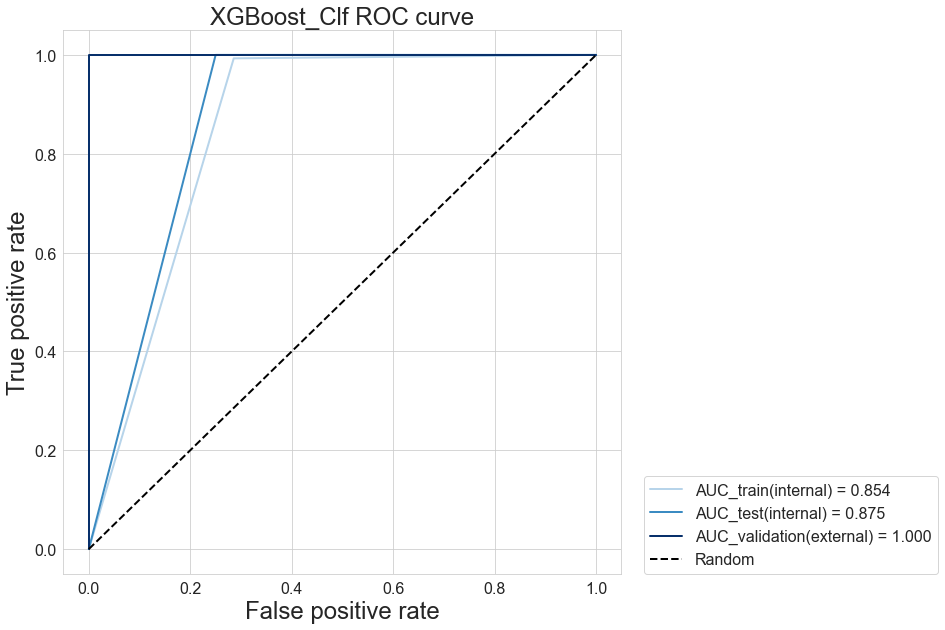

In [7]:
from lib.main_func_p4 import plot_ROC_curve
from sklearn.metrics import roc_curve, auc, classification_report

# Calcular probabilidades del conjunto de datos externo
pred_valid = xgbc_tuned.predict(X_valid)
df_external_valid['prediction'] = pred_valid

prediction_prob_valid = np.array(xgbc_tuned.predict_proba(X_valid)[:,1])
df_external_valid['prediction_prob'] = prediction_prob_valid

fpr_valid, tpr_valid, _ = roc_curve(y_valid, prediction_prob_valid)
auc_score_unsee = auc(fpr_valid, tpr_valid)
metrics_ROC_valid = (fpr_valid, tpr_valid, auc_score_unsee)

model_name = f'XGBoost_Clf'
metrics_ROC = results_ROC_fp.copy()
metrics_ROC.extend([metrics_ROC_valid])
metrics_ROC_name = ['train(internal)', 'test(internal)', 'validation(external)']

# print(classification_report(y_valid, pred_valid))
plot_ROC_curve(metrics_ROC, metrics_ROC_name, model_name, path_file=path_file, save_fig=True)

### Calibration curve
#### Train dataset

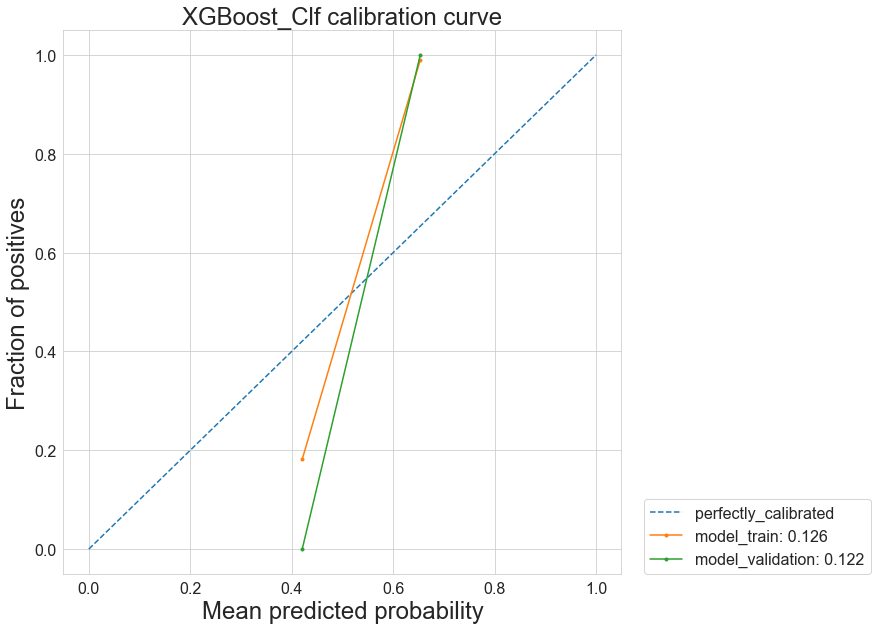

In [8]:
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve

df_internal = pd.read_pickle(f'{path_file}_dataset_train')
X_test, y_test = df_internal[fp_name].tolist(), df_internal['activity'].tolist()
# Calcular probabilidades del conjunto de datos interno
pred_test = xgbc_tuned.predict(X_test)
df_internal['prediction'] = pred_test

prediction_prob_test = np.array(xgbc_tuned.predict_proba(X_test)[:,1])
df_internal['prediction_prob'] = prediction_prob_test

model_name = f'XGBoost_Clf'
plots_list = [df_internal, df_external_valid]
plots_name_list = ['model_train', 'model_validation']

plot_calibration_curve(plots_list, plots_name_list, model_name, path_file=path_file, save_fig=True)

## Uso del modelo

In [20]:
print(f'Datos iniciales: {df_external_valid.shape}')

# Resample
df_valid_external_rsmpl = resampling_set(df_external_valid, mode='under_sampling', ratio=1)
print('Submuestreo')

df_valid_external_rsmpl['type'] = 'valid_inactive'
df_valid_external_rsmpl.loc[df_valid_external_rsmpl[df_valid_external_rsmpl.activity == 1.0].index, 'type'] = 'valid_active'
df_valid_external_rsmpl.reset_index(drop=True, inplace=True)
print(df_valid_external_rsmpl.shape)
print(df_valid_external_rsmpl.activity.value_counts())

df_valid_external_rsmpl = df_valid_external_rsmpl[['type', fp_name, 'activity', 'prediction', 'prediction_prob']]
df_valid_external_rsmpl.head()

Datos iniciales: (124, 5)
Submuestreo
(10, 6)
1.0    5
0.0    5
Name: activity, dtype: int64


,type,morgan2_c,activity,prediction,prediction_prob
0,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
1,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.420676
2,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0,0,0.420676
3,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
4,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408


In [16]:
df_valid_external_rsmpl

,type,morgan2_c,activity,prediction,prediction_prob
0,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
1,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.420676
2,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0,0,0.420676
3,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
4,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
5,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
6,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.653408
7,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0,0,0.420676
8,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0,0,0.420676
9,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.420676


### Predicciones

Con el modelo cargado, clasificar cada compuesto del conjunto decoys en activo: 1.0 o inactivo 0.0

In [21]:
x_decoy = df_decoys[fp_name].tolist()
pred_decoy = xgbc_tuned.predict(x_decoy)
prediction_prob = xgbc_tuned.predict_proba(x_decoy)[:,1]
prediction_prob = np.array(prediction_prob)
df_decoys['activity'] = 0.0
df_decoys['prediction'] = pred_decoy
df_decoys['prediction_prob'] = prediction_prob
df_decoys.head()

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0,1,0.653408
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408


In [24]:
df_decoys

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0,1,0.653408
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
...,...,...,...,...,...
40494,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
40495,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
40496,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408
40497,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.653408


In [22]:
df_decoys.prediction.value_counts()

1    40165
0      334
Name: prediction, dtype: int64

valid_active      5
valid_inactive    5
decoy             5
Name: type, dtype: int64


C:\Users\caramirezs\anaconda3\envs\ML_for_DD\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 1080x1080 with 0 Axes>

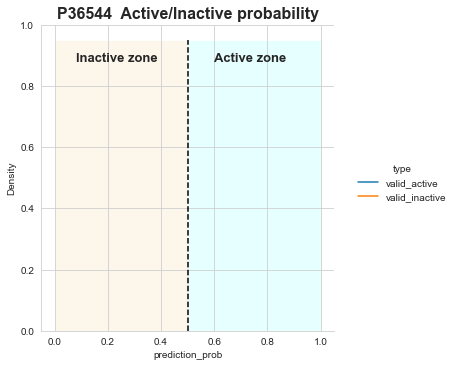

In [12]:
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_probability_curve

df = pd.concat([df_valid_external_rsmpl, df_decoys], ignore_index=True)
print(df.type.value_counts())

hue_order=['valid_active', 'valid_inactive']
plot_probability_curve(df, uniprot_id, hue_order=hue_order,
                       path_file=path_file, save_fig=True)

C:\Users\caramirezs\anaconda3\envs\ML_for_DD\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 1080x1080 with 0 Axes>

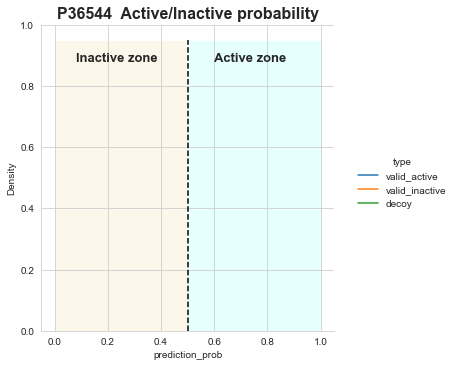

In [13]:
hue_order=['valid_active', 'valid_inactive', 'decoy']
plot_probability_curve(df, uniprot_id, hue_order=hue_order,
                       path_file=path_file, name_mod='(decoys)', save_fig=True)

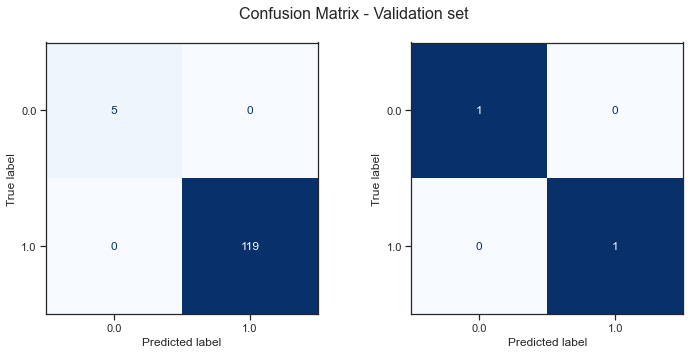

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Confusion Matrix - Validation set', size=16)
disp1 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid, y_valid,
                                              cmap=plt.cm.Blues, normalize=None,
                                              colorbar=False, ax=ax1)
disp2 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid, y_valid,
                                              cmap=plt.cm.Blues, normalize='true',
                                              colorbar=False, ax=ax2)
plt.savefig(f'{path_file}_IMG06_ConfusionMatrix.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()